### Setting up data

In [1]:
import pandas as pd
import re

# Step 1: Load the data
df = pd.read_excel('Data.xlsx')

# Step 2: Parse disease probabilities
def parse_disease(disease_str):
    diseases = {}
    if pd.isna(disease_str):
        return {}
    regex = re.compile(r"([\w\s]+?)\s*\((\d+)-(\d+)%\)")
    matches = regex.findall(disease_str)
    for match in matches:
        disease, low, high = match
        avg_prob = (int(low) + int(high)) / 2
        diseases[disease.strip()] = avg_prob
    return diseases

df['Diseases'] = df['Associated disease'].apply(parse_disease)

# Step 3: Create target columns
all_diseases = set()
for row in df['Diseases']:
    all_diseases.update(row.keys())

for disease in all_diseases:
    df[f'prob_{disease.replace(" ", "_").lower()}'] = df['Diseases'].apply(lambda x: x.get(disease, 0))

# Drop original disease-related columns
df.drop(columns=['Associated disease', 'Diseases'], inplace=True)

df

,Food item (100g),Food category,Energy (kcal),Fat (g),Sugar (g),Sodium (mg),Cholesterol (mg),Carbs (g),Protein (g),Fiber (g),Threshold value (g/day),prob_metabolic_syndrome,prob_hypertension,prob_colon_cancer,prob_diabetes,prob_obesity,prob_hypertension_risk,prob_dental_caries,prob_heart_disease
0,Whole milk,Dairy products,63,3.6,4.6,42,0,4.6,3.4,0.0,500,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0
1,Semi-skimmed milk,Dairy products,46,1.7,4.7,43,0,4.7,3.5,0.0,600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Skimmed milk,Dairy products,34,0.3,4.8,44,0,4.8,3.5,0.0,800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1% milk,Dairy products,41,1.0,4.8,44,0,4.8,3.5,0.0,700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,UHT milk,Dairy products,46,1.6,4.9,50,0,4.9,3.3,0.0,600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,Cookies,Sweets & Sugars,488,25.1,35.2,327,54,64.0,5.5,1.8,40,0.0,0.0,0.0,30.0,22.5,0.0,0.0,0.0
85,Jelly,Sweets & Sugars,278,0.1,68.5,10,0,69.2,0.5,0.3,25,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0
86,Jam,Sweets & Sugars,278,0.1,49.1,17,0,69.0,0.7,0.3,30,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0
87,Cake,Sweets & Sugars,369,15.7,36.7,334,62,57.8,4.2,1.4,50,0.0,0.0,0.0,30.0,22.5,0.0,0.0,0.0


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 4: One-hot encode Food category
df = pd.get_dummies(df, columns=['Food category'], drop_first=True)

# Step 5: Define features and targets
feature_columns = [
    'Energy (kcal)', 'Fat (g)', 'Sugar (g)', 'Sodium (mg)',
    'Cholesterol (mg)', 'Carbs (g)', 'Protein (g)', 'Fiber (g)', 'Threshold value (g/day)'
]

# Add one-hot encoded columns to feature set
one_hot_columns = [col for col in df.columns if col.startswith('Food category_')]
feature_columns += one_hot_columns

target_columns = [col for col in df.columns if col.startswith('prob_')]

# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(df[feature_columns], df[target_columns], test_size=0.2, random_state=42)

# Reset index to align with original DataFrame after train-test split
X_test = X_test.copy()
y_test = y_test.copy()

# Get corresponding rows from original df for 'Food item (100g)'
food_items_test = df.loc[X_test.index, 'Food item (100g)'].reset_index(drop=True)

# Combine into a single DataFrame
test_data = pd.concat([food_items_test, X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

# Print the combined DataFrame
test_data

,Food item (100g),Energy (kcal),Fat (g),Sugar (g),Sodium (mg),Cholesterol (mg),Carbs (g),Protein (g),Fiber (g),Threshold value (g/day),...,Food category_Sweets & Sugars,Food category_Vegetables,prob_metabolic_syndrome,prob_hypertension,prob_colon_cancer,prob_diabetes,prob_obesity,prob_hypertension_risk,prob_dental_caries,prob_heart_disease
0,"Veal, roast",359,16.0,0.0,70,90,0.0,13.0,0.0,120,...,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.5
1,Instant Noodles,385,14.5,1.9,1310,0,54.7,9.1,2.1,100,...,False,False,22.5,35.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Roast beef, oven-cooked",459,42.0,0.0,60,95,0.0,19.0,0.0,70,...,False,False,0.0,0.0,17.5,0.0,0.0,0.0,0.0,27.5
3,Greek style yogurt,133,10.2,4.5,66,0,4.8,5.7,0.0,300,...,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Sardines, canned",212,11.0,0.0,200,100,0.0,26.0,0.0,100,...,False,False,0.0,12.5,0.0,0.0,0.0,0.0,0.0,0.0
5,Whole milk,63,3.6,4.6,42,0,4.6,3.4,0.0,500,...,False,False,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0
6,Salami,378,30.5,0.4,1890,86,1.3,21.7,0.0,30,...,False,False,0.0,35.0,30.0,0.0,0.0,0.0,0.0,0.0
7,Hydrogenated cooking fat,665,100.0,0.0,0,0,0.0,0.0,0.0,10,...,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0
8,Low fat yogurt,57,1.0,7.5,63,0,7.8,4.8,0.0,500,...,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Cottonseed oil,893,100.0,0.0,0,0,0.0,0.0,0.0,30,...,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0


In [3]:
# Step 7: Scale numeric features (only original numeric features, not one-hot columns)
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(X_train.iloc[:, :9])  # first 9 columns are numeric
X_test_numeric = scaler.transform(X_test.iloc[:, :9])

# Concatenate scaled numeric + one-hot encoded parts
X_train_scaled = pd.DataFrame(X_train_numeric, columns=feature_columns[:9], index=X_train.index)
X_train_scaled[one_hot_columns] = X_train[one_hot_columns]

X_test_scaled = pd.DataFrame(X_test_numeric, columns=feature_columns[:9], index=X_test.index)
X_test_scaled[one_hot_columns] = X_test[one_hot_columns]

### Different Models

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

models = {
    "Decision Tree": Pipeline([
        ('regressor', GridSearchCV(
            DecisionTreeRegressor(random_state=42),
            param_grid={'max_depth': [3, 5, 10, None]},
            cv=3, n_jobs=-1
        ))
    ]),
    
    "Random Forest": Pipeline([
        ('regressor', GridSearchCV(
            RandomForestRegressor(random_state=42),
            param_grid={'n_estimators': [100, 200], 'max_depth': [10, 20, None]},
            cv=3, n_jobs=-1
        ))
    ]),

    "XGBoost": Pipeline([
        ('regressor', GridSearchCV(
            XGBRegressor(missing=np.nan, random_state=42),
            param_grid={'n_estimators': [100, 200], 'max_depth': [3, 6, 10], 'learning_rate': [0.01, 0.1]},
            cv=3, n_jobs=4
        ))
    ]),

    # Neural network
    "MLP Regressor": Pipeline([
        ('regressor', MultiOutputRegressor(
            GridSearchCV(
                MLPRegressor(max_iter=30000, random_state=42),
                param_grid={'hidden_layer_sizes': [(100,), (50, 50)], 'alpha': [0.0001, 0.001]},
                cv=3, n_jobs=-1
            )
        ))
    ]),

    "Linear Regression": Pipeline([
        ('regressor', LinearRegression())
    ]),

    "Ridge Regression": Pipeline([
        ('regressor', Ridge(alpha=1.0, max_iter=30000))
    ]),

    "KNN Regressor": Pipeline([
        ('regressor', GridSearchCV(
            KNeighborsRegressor(),
            param_grid={'n_neighbors': [3, 5, 7, 9]},
            cv=3, n_jobs=-1
        ))
    ])
}

# Lists to store evaluation metrics
mae_values = []
r2_values = []
model_names = []

# Loop through each model
for name, model in models.items():
    # Fit the model
    model.fit(X_train_scaled, y_train)

    # If model is GridSearchCV, extract best_estimator_
    if isinstance(model, Pipeline):
        best_model = model.named_steps['regressor'].best_estimator_ if isinstance(model.named_steps['regressor'], GridSearchCV) else model.named_steps['regressor']
    else:
        best_model = model

    # Predict
    y_pred = best_model.predict(X_test_scaled)
    predicted_df = pd.DataFrame(y_pred, columns=target_columns, index=y_test.index)

    # Combine with actual values
    comparison_df = pd.concat([y_test, predicted_df.add_suffix('_predicted')], axis=1)
    actual_columns = [col for col in comparison_df.columns if not col.endswith('_predicted')]
    predicted_columns = [col + '_predicted' for col in actual_columns]
    new_column_order = [item for pair in zip(actual_columns, predicted_columns) for item in pair]
    comparison_df = comparison_df[new_column_order]

    # Metrics
    model_mae = 0
    model_r2 = 0

    for actual, predicted in zip(actual_columns, predicted_columns):
        mae = mean_absolute_error(comparison_df[actual], comparison_df[predicted])
        r2 = r2_score(comparison_df[actual], comparison_df[predicted])
        model_mae += mae
        model_r2 += r2

    model_mae /= len(target_columns)
    model_r2 /= len(target_columns)

    # Store results
    mae_values.append(model_mae)
    r2_values.append(model_r2)
    model_names.append(name)

for i in range(len(model_names)):
    print(f"\n{model_names[i]} Results:")
    print(f"MAE: {mae_values[i]:.4f}\tR² Score: {(r2_values[i] * 100):.2f}%")


Decision Tree Results:
MAE: 3.1722	R² Score: 41.34%

Random Forest Results:
MAE: 1.9406	R² Score: 72.40%

XGBoost Results:
MAE: 2.5402	R² Score: 55.63%

MLP Regressor Results:
MAE: 2.8058	R² Score: 51.80%

Linear Regression Results:
MAE: 3.7143	R² Score: 42.69%

Ridge Regression Results:
MAE: 3.2573	R² Score: 48.66%

KNN Regressor Results:
MAE: 1.8461	R² Score: 72.72%


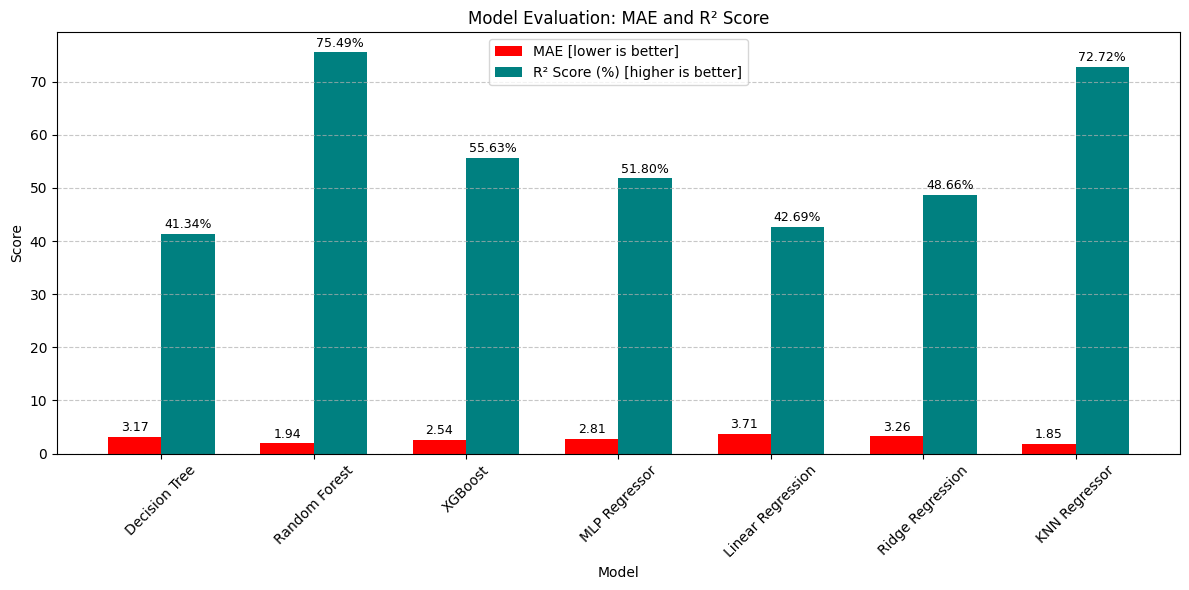

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Convert R² scores to percentages for consistency
r2_percentages = [r2 * 100 for r2 in r2_values]

# Set the figure size
plt.figure(figsize=(12, 6))

# Define bar width
bar_width = 0.35
x = np.arange(len(model_names))

# Plot MAE
mae_bars = plt.bar(x - bar_width / 2, mae_values, width=bar_width, label='MAE [lower is better]', color='red')

# Plot R² Score
r2_bars = plt.bar(x + bar_width / 2, r2_percentages, width=bar_width, label='R² Score (%) [higher is better]', color=(0.0, 0.5, 0.5))

# Add value labels on top of the bars
for bar in mae_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}', ha='center', va='bottom', fontsize=9)

for bar in r2_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}%', ha='center', va='bottom', fontsize=9)

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Evaluation: MAE and R² Score')
plt.xticks(ticks=x, labels=model_names, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show plot
plt.tight_layout()
plt.show()